In [1]:
import seaborn as sns
from adaptive.compute import collect
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm
from time import time
from glob import glob
import scipy.stats as stats
from IPython.display import display, HTML
from adaptive.saving import *
import dill as pickle
from pickle import UnpicklingError
import copy
from itertools import compress
import scipy.stats as stats
from plot_utils import *
import os
sns.set(font_scale=1.2)
# %matplotlib inline
# %reload_ext autoreload
# %autoreload 2

# Sequential classification with bandit feedback
$85$ multi-class classification from OpenML(https://www.openml.org), see below for the list of darasets

### Policies:
1. __optimal contextual policy__ that assigns each covariate to its correct label;
2. __best fixed_arm policy__ that always assigns each covariates to the label with most samples;
3. __contrast__ between the above policies.
We demonstrate the contrast estimation here.

### Compared estimation methods:
- DM: direct method;
- DR: doubly-robust method with weight $h_t=1$;
- non-contextual `MinVar` $h_t = 1/E[\sum_w\frac{\pi^2(x,w)}{e_t(x,w)}]$
- non-contextual `StableVar` $h_t = 1/\sqrt{E[\sum_w\frac{\pi^2(x,w)}{e_t(x,w)}]}$
- contextual `MinVar` $h_t(x) = 1/\sum_w\frac{\pi^2(x,w)}{e_t(x,w)}$
- contextual `StableVar` $h_t(x) = 1/\sum_w\frac{\pi^2(x,w)}{e_t(x,w)}$

## Read saving results

In [2]:
def read_data(name):
    results = read_files(f'{name}*')
    print(len(results))
    if os.path.exists(f"{name}_stats.csv"):
        df_stats = pd.read_csv(f"{name}_stats.csv")
    else:
        df_stats, _, _ = generate_data_frames(results)
        df_stats.to_csv(f"{name}_stats.csv")
    return df_stats

In [3]:
df_stats =  read_data("results/classification")
df_lite = merge_dataset_df(df_stats)

Found 56 files.
1120


In [4]:
df_lite['dgp'].unique()

array(['LEV', 'Long', 'PhishingWebsites', 'PizzaCutter3', 'SPECT',
       'Satellite', 'allrep', 'autoUniv-au1-1000', 'balance-scale',
       'banknote-authentication', 'blood-transfusion-service-center',
       'car', 'cardiotocography', 'cmc', 'coil2000', 'collins',
       'credit-g', 'delta_ailerons', 'diabetes', 'dis', 'haberman',
       'heart-statlog', 'ionosphere',
       'jungle_chess_2pcs_endgame_elephant_elephant',
       'jungle_chess_2pcs_endgame_panther_lion', 'kc3', 'kr-vs-kp',
       'mammography'], dtype=object)

## Analyze characteristics of datasets: #classes, #features, #observations

In [5]:
analyze_characteristics(df_lite)


#Classes: =2: 22; >2,<=8: 5; >8: 1
#Features: <=10: 10; >10, <=50: 17; >50: 1 
#Observations: <=1k: 12; >1k, <=10k: 14; >10k: 2


## Plots

In [6]:
weight, policy = "uniform", "optimal-best_arm"
df_stats = df_lite.copy()
bias = np.array(df_stats.query(
    f"weight=='{weight}' & policy=='{policy}' ")['bias'])
std = np.array(df_stats.query(
    f"weight=='{weight}' & policy=='{policy}' ")['se'])
baseline = np.sqrt(bias**2 + std**2)


### Use DR as a baseline and compare it with other methods; evaluating contrast
Every subplot corresponds to an estimation method, wherein each point denotes a dataset, and its $(x,y)$ coordinates are bias and standard error normalized by RMSE of DR estimate on the same dataset.

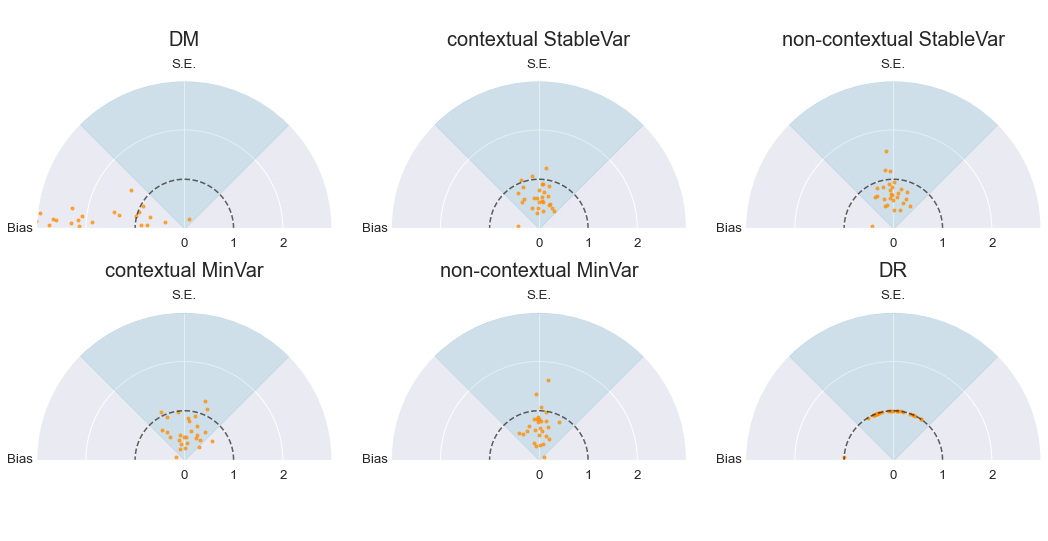

In [7]:
# def plot_radius(df_stats, weight, policy):
#     """
#     Use one weighting method as a baseline, and plot others (bias, S.E.) normalized by the RMSE of the baseline.
#     """
baseline = get_baseline(df_lite, weight, policy)
f, ax = plt.subplots(nrows=2, ncols=3,  figsize=(
    3*6, 2*6), subplot_kw=dict(polar=True))
names = dict(propscore_X='contextual MinVar', propscore_expected='non-contextual MinVar',
             lvdl_expected='non-contextual StableVar', lvdl_X='contextual StableVar',
             DM='DM', uniform='DR')
for c, (w, df_w) in enumerate(df_stats.query(f"policy=='{policy}'").groupby('weight')):
    i, j = c // 3, c % 3
    bias_w = np.array(df_w['bias'])
    std_w = np.array(df_w['se'])
    theta = np.pi/2 - np.arctan(bias_w / (std_w + 0.001))
    r = np.sqrt(bias_w ** 2 + std_w ** 2) / baseline
    ax[i, j].plot(theta, r, '.', c='darkorange', alpha=0.7)
    ax[i, j].plot(np.linspace(0, np.pi, 50), [1]*50, 'k--', alpha=0.7)
    ax[i, j].fill_between(np.linspace(
        np.pi/4, 3*np.pi/4, 50), 0, 3, alpha=0.2, color='c')

    ax[i, j].set_thetamin(0)
    ax[i, j].set_thetamax(180)
    ax[i, j].set_rmax(3)
    ax[i, j].set_title(f'{names[w]}', y=0.85, fontsize=20)
    ax[i, j].set_rticks([0, 1, 2])  # less radial ticks
    ax[i, j].set_xticks([0, np.pi/2, np.pi])
    ax[i, j].set_xticklabels(['', "S.E.", 'Bias'])

plt.subplots_adjust(hspace=-0.45)

In [8]:
def get_baseline(df_stats, weight, policy):
    bias = np.array(df_stats.query(
        f"weight=='{weight}' & policy=='{policy}' ")['bias'])
    std = np.array(df_stats.query(
        f"weight=='{weight}' & policy=='{policy}' ")['se'])
    baseline = np.sqrt(bias**2 + std**2)
    return baseline

### Compare contextual weighting versus non-contextual weighting; evaluating contrast
In the left panel, each point denotes a dataset, and its $(x,y)$ coordinates are bias and standard error of contextual `MinVar` normalized by RMSE of non-contextual `MinVar` on the same dataset. Same visualization is applied to contextual and non-contextual `StableVar`  in the right panel.

In [9]:

def plot_polar_ax(df_stats, weight, baseline_weight, policy, ax, name):
        baseline = get_baseline(df_stats, baseline_weight, policy)
        bias_w = np.array(df_stats.query(
            f" weight=='{weight}' & policy=='{policy}'")['bias'])
        std_w = np.array(df_stats.query(
            f" weight=='{weight}' & policy=='{policy}'")['se']) + 0.01
        theta = np.pi/2 - np.arctan(bias_w / std_w)
        r = np.sqrt(bias_w ** 2 + std_w ** 2) / baseline
        ax.plot(theta, r, '.', c='darkorange', alpha=0.7)
        ax.plot(np.linspace(0, np.pi, 50), [1]*50, 'k--', alpha=0.7)
        ax.fill_between(np.linspace(np.pi/4, 3*np.pi/4, 50),
                        0, 2, alpha=0.2, color='c')
        ax.set_thetamin(0)
        ax.set_thetamax(180)
        ax.set_rmax(2)
        ax.set_title(name, y=0.85, fontsize=15)
        ax.set_rticks([0, 1, 2])  # less radial ticks
        ax.set_xticks([0, np.pi/2, np.pi])
        ax.set_xticklabels(['', "S.E.", 'Bias'])

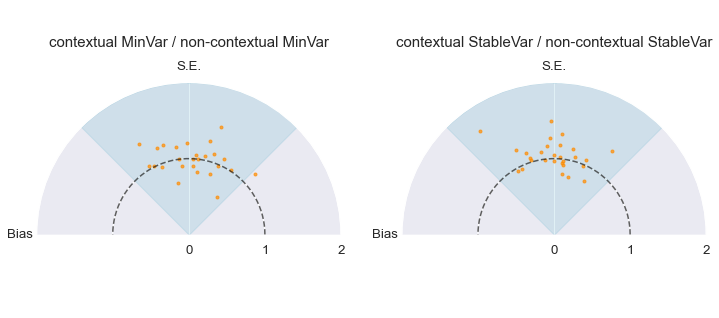

In [10]:
f, ax = plt.subplots(nrows=1, ncols=2,  figsize=(
        2*6, 1*6), subplot_kw=dict(polar=True))
plot_polar_ax(df_lite, 'propscore_X', 'propscore_expected', policy,
              ax[0], 'contextual MinVar / non-contextual MinVar')
plot_polar_ax(df_lite, 'lvdl_X', 'lvdl_expected', policy,
              ax[1], 'contextual StableVar / non-contextual StableVar')

### Compare MinVar versus StableVar; evaluating contrast
Each point corresponds to a dataset. The $(x,y)$ coordinates are bias and standard error of `MinVar` normalized by its `StableVar` counterpart in forms of both noncontextual weighting (left panel) and contextual weighting (right panel).

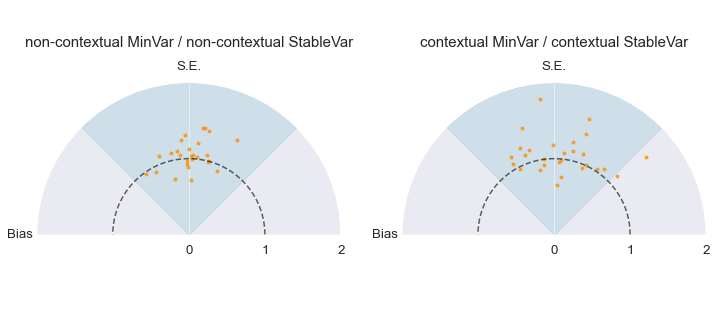

In [11]:
f, ax = plt.subplots(nrows=1, ncols=2,  figsize=(
        2*6, 1*6), subplot_kw=dict(polar=True))
plot_polar_ax(df_lite, 'propscore_expected', 'lvdl_expected', policy,
                  ax[0], 'non-contextual MinVar / non-contextual StableVar')
plot_polar_ax(df_lite, 'propscore_X', 'lvdl_X', policy,
              ax[1], 'contextual MinVar / contextual StableVar')